In [3]:
"""
Created on Tuesday 9 Feb 2023
Author: ZAW
"""
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from scipy.optimize import curve_fit
from scipy import signal
from tsmoothie.smoother import LowessSmoother
import csv

In [5]:
# Read dataset for a , b, c value
# data path
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/data.csv'
data_path = os.path.join(dirname,data_file)
data = pd.read_csv(data_path)

In [94]:
path

'/Users/zaw/Desktop/eye_movements(sp)/gain'

In [95]:
# View top 10 rows in dataframe
data.head(10)

,Label,Patient,A1_1Deg,A1_1Deg_err,B1_1Deg,B1_1Deg_err,C1_1Deg,C1_1Deg_err,1_Deg_ResSoS_1,1Deg_AdjR2_1,...,8_Deg_ResSoS_1,8Deg_AdjR2_1,A2_8Deg,A2_8Deg_err,B2_8Deg,B2_8Deg_err,C2_8Deg,C2_8Deg_err,8_Deg_ResSoS_2,8Deg_AdjR2_2
0,Not_Parkinson's,PD001,10.388190,0.006132,0.049329,0.000006,0.011989,0.000337,8928.709194,0.990598,...,6698.838281,0.951413,10.273124,0.044206,0.386347,0.000384,0.037356,0.002439,6809.455800,0.939095
1,Not_Parkinson's,PD002,10.429055,0.006929,0.049478,0.000007,0.002837,0.000379,11388.604704,0.988092,...,4769.901822,0.967360,11.482500,0.049154,0.395412,0.000380,-0.002486,0.002419,8383.481840,0.939586
2,Not_Parkinson's,PD003,10.097088,0.005091,0.049368,0.000006,0.005707,0.000287,6140.292312,0.993141,...,3488.747176,0.968709,10.084338,0.019838,0.394595,0.000174,-0.035466,0.001106,1349.962240,0.987259
3,Not_Parkinson's,PD004,10.482881,0.022179,0.049585,0.000023,0.016056,0.001212,117748.979710,0.879372,...,10972.045844,0.920137,11.493414,0.048867,0.401386,0.000377,-0.042463,0.002395,8242.136178,0.940370
4,Not_Parkinson's,PD005,10.181273,0.008833,0.049368,0.000010,0.001569,0.000494,18447.340517,0.979692,...,18268.960666,0.809586,10.370348,0.036121,0.395392,0.000308,-0.030769,0.001960,4485.300264,0.960035
5,Not_Parkinson's,PD006,10.302529,0.010450,0.049283,0.000011,0.019735,0.000580,25994.527943,0.972249,...,7175.782112,0.938474,10.356903,0.067627,0.410282,0.000584,-0.052723,0.003707,16046.923323,0.859535
6,Not_Parkinson's,PD007,9.934379,0.007838,0.049209,0.000009,0.003633,0.000449,14490.496516,0.983200,...,1465.027123,0.985896,9.801698,0.024067,0.397850,0.000217,-0.045138,0.001380,1986.965945,0.980134
7,Not_Parkinson's,PD008,9.861257,0.026999,0.049220,0.000030,0.051865,0.001576,176009.839073,0.798036,...,15508.422642,0.870504,8.591437,0.105215,0.415729,0.001098,-0.078941,0.006967,39005.324498,0.507026
8,Not_Parkinson's,PD009,10.221777,0.005149,0.049244,0.000006,0.002274,0.000287,6253.730577,0.993152,...,849.603210,0.992275,10.305625,0.022845,0.396998,0.000196,-0.056233,0.001244,1783.111545,0.983816
9,Not_Parkinson's,PD010,10.244784,0.017579,0.050004,0.000019,-0.015054,0.000981,73606.211066,0.920684,...,13818.787560,0.878166,10.997960,0.085181,0.406918,0.000690,-0.043189,0.004387,25335.919452,0.802179


In [1607]:
# read SPEM data
data_013 = 'data/Parkinson_pursuit testing_Rec 180.xlsx'
data_path = os.path.join(dirname,data_013)
data_sp = pd.read_excel(data_path)

/Users/zaw/miniforge3/envs/ds/lib/python3.9/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


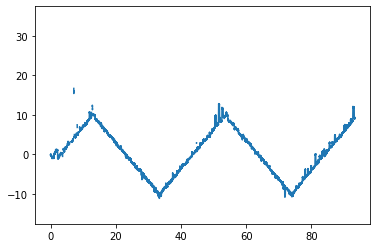

In [1696]:
plt.plot(one_deg_time_eye,one_deg_pos_eye)

In [1701]:
# Pupil size
pupil_size = np.array(data_sp['PupilRight'][0:28000])

In [1702]:
# for eye pixel calculating
def px_deg_eye(data,dominant_eye):
    time_eye = []
    pos_eye = []
    if dominant_eye == 'right':
        for y in data['GazePointRightX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    elif dominant_eye == 'left':
        for y in data['GazePointLeftX (ADCSpx)']:
            new_y = round((y - 960)/49.6,4) # horizontal center:960x540 pixel : 1 deg = 49.6 pixel
            pos_eye.append(new_y)
    for x in range(1,len(pos_eye)+1):
        new_x = round((1/300)*x,4) # for tobii's eye tracker with 300 Hz sampling rate
        time_eye.append(new_x)
    return time_eye,pos_eye

In [1703]:
def filter_blinks(gaze_point_right_x, gaze_time_input, pupil_size=pupil_size, consecutive_missing_points_threshold=60):
    # Convert input list to NumPy array
    gaze_point_right_x = np.array(gaze_point_right_x)
    gaze_time = gaze_time_input

    # Create a mask for missing data (NaN) in GazePointRightX
    missing_mask = np.isnan(gaze_point_right_x) & np.isnan(pupil_size)

    # Count consecutive missing gaze points (NaNs)
    consecutive_missing_points = np.diff(np.where(np.concatenate(([missing_mask[0]], missing_mask[:-1] != missing_mask[1:], [True])))[0])[::2]

    # Count the number of blinks based on the consecutive_missing_points_threshold
    num_blinks = np.sum(consecutive_missing_points >= consecutive_missing_points_threshold)

     # Remove the missing data (NaN) using the mask
    gaze_point_right_x_no_blinks = gaze_point_right_x[~missing_mask]

    # Also remove the repective time values
    gaze_time = gaze_time[~missing_mask]

    #print(f"Number of blinks: {num_blinks}")

    return gaze_point_right_x_no_blinks, gaze_time

In [1704]:
# event starts and ends
option = ['URLStart','URLEnd'] # This is the values in the Studio event column where stimuli start and end events from dataset
sti = data_sp[data_sp['StudioEvent'].isin(option)].index # Caculating start and end of stimuli
data_eye_hc_first = data_sp[sti[0]:sti[0]+28000] # Real recoding starting time
#data_eye_hc_first = data_sp[sti[0]+4000:sti[0]+28200] # Real recoding starting time
one_deg_time_eye , one_deg_pos_eye =  px_deg_eye(data_eye_hc_first,'right')

In [1705]:
sub_013 = {'Time':one_deg_time_eye,'POS':one_deg_pos_eye}
df_sub_013 = pd.DataFrame(data=sub_013)
#df_sub_013.to_excel('sub013.xlsx')

In [1706]:
# # filter blinks
position,time = filter_blinks(df_sub_013['POS'],df_sub_013['Time'])


data_fil= {'Time':time,'POS':position}#,#'PUP':pupil_size}
data_fil = pd.DataFrame(data_fil)
# #data_pd001['POS'] = pos_no_blinks
# Remove the spike values and interpolate
window_size = 7
data_fil['POS'] = data_fil['POS'].rolling(window=window_size, center=True).median()

# # interpolate
data_fil['POS'] = data_fil['POS'].interpolate(method='spline', order=5)

one_deg_time_eye , one_deg_pos_eye =  data_fil['Time'], data_fil['POS']

In [1707]:
# Check Nan or Inf for time
nan_mask = one_deg_time_eye.isna()
inf_mask = np.isinf(one_deg_time_eye)
non_or_inf_mask = nan_mask | inf_mask
total_nan = nan_mask.sum()
total_inf = inf_mask.sum()

nan_or_inf_mask = nan_mask | inf_mask

total_nan_or_inf = nan_or_inf_mask.sum()

# Print the results
print("Total NaN values:", total_nan)
print("Total inf values:", total_inf)
print("Total NaN and inf values:", total_nan_or_inf)

Total NaN values: 0
Total inf values: 0
Total NaN and inf values: 0


In [1708]:
# Check Nan or Inf for pos
nan_mask = one_deg_pos_eye.isna()
inf_mask = np.isinf(one_deg_pos_eye)
non_or_inf_mask = nan_mask | inf_mask
total_nan = nan_mask.sum()
total_inf = inf_mask.sum()

nan_or_inf_mask = nan_mask | inf_mask

total_nan_or_inf = nan_or_inf_mask.sum()

# Print the results
print("Total NaN values:", total_nan)
print("Total inf values:", total_inf)
print("Total NaN and inf values:", total_nan_or_inf)

Total NaN values: 4
Total inf values: 0
Total NaN and inf values: 4


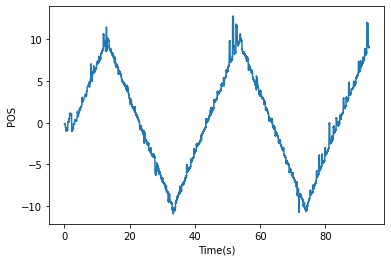

In [1709]:
# Plot the data
plt.plot(one_deg_time_eye,one_deg_pos_eye)
plt.xlabel('Time(s)')
plt.ylabel('POS')
plt.show()

In [1711]:
data['Position']


0         0.0033
1         0.0067
2         0.0100
3         0.0133
4         0.0167
          ...   
26997    89.9933
26998    89.9967
26999    90.0000
27000    90.0033
27001    90.0067
Name: Position, Length: 27002, dtype: float64

In [1712]:
y_data = one_deg_time_eye
x_data = one_deg_pos_eye

In [1714]:
y_data

0         0.0033
1         0.0067
2         0.0100
3         0.0133
4         0.0167
          ...   
27995    93.3200
27996    93.3233
27997    93.3267
27998    93.3300
27999    93.3333
Name: Time, Length: 27666, dtype: float64

### Working Algorithms

In [43]:
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/two_deg.csv'
data_path = os.path.join(dirname,data_file)
# data = pd.read_csv(data_path)
data= pd.read_csv(data_path)

In [44]:
data_hc = data[['x1_PD001','y1_PD001']]

In [45]:
y_data = data_hc['x1_PD001']
x_data = data_hc['y1_PD001']

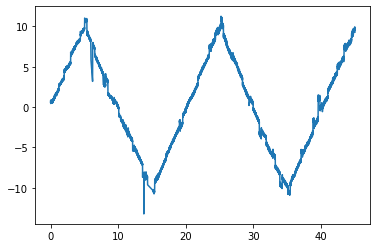

In [46]:
plt.plot(y_data,x_data)

In [47]:
#import CSV data
path = os.getcwd()
dirname = os.path.dirname(path)
data_file = 'data/2_degSti.xlsx'
data_path = os.path.join(dirname,data_file)
rawdata = pd.read_excel(data_path)
data_st = np.array(rawdata[1:],dtype=np.float)
time = data_st[:,1]
position = data_st[:,0]

/var/folders/hj/4_1_bgn11_dgm99bq0lnjxl80000gn/T/ipykernel_15188/1278966000.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_st = np.array(rawdata[1:],dtype=np.float)


In [48]:
# Trigonometric functions

# Define the function
def func(x, a, b, c):  #Position as a function of time.
    return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

#initial guesses
#for 1 degree per second: [10, 0.05, 0]
#for 2 degrees per second: [10, 0.1, 0]
#for 4 degrees per second: [10, 0.2, 0]
#for 6 degrees per second: [10, 0.3, 0]
#for 8 degrees per second: [10, 0.4, 0]
InitialGuess = [10, 0.1, 0]

# Perform curve fitting
popt, pcov = curve_fit(func,position,time, p0=InitialGuess)

# Extract the optimal values of a, b, and c
a, b, c = popt
print("a =", a)
print("b =", b)
print("c =", c)

a = 9.989823272284305
b = 0.10000069841142097
c = -2.3002702245225147e-05


In [49]:
# # # # Trigonometric functions

# # # # Define the function
# # # def func(x, a, b, c):  #Position as a function of time.
# # #     return a*(2/np.pi)*np.arcsin(np.sin(np.pi*(b*x+c)))

# # # # drop NaN
# # # y_data = one_deg_time_eye.ffill()
# # # x_data = one_deg_pos_eye.ffill()

# # # y_data = one_deg_time_eye.bfill()
# # # x_data = one_deg_pos_eye.bfill()

# # # # # Example data points (x, y) - replace these with your actual data
# # # # x_data = np.array(one_deg_time_eye)
# # # # y_data = np.array(one_deg_pos_eye)


# # # #initial guesses
# # InitialGuess = [10, 0.05, 0]

# # # Perform curve fitting
# # popt, pcov = curve_fit(func, x_data, y_data, p0=InitialGuess)

# # # Extract the optimal values of a, b, and c
# # a, b, c = popt

# # print("Optimal values of a, b, and c:")
# print("a =", a)
# print("b =", b)
# print("c =", c)

In [50]:
# a = 10.19274
# b = 0.04942
# c = 0.00533

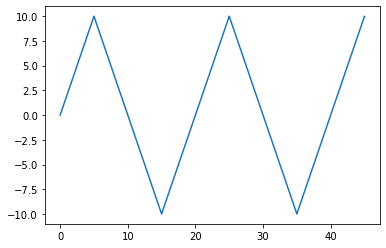

In [51]:
# Fit time
fit_time = func(y_data,a,b,c)
plt.plot(y_data,fit_time)
plt.show()

In [52]:
# Different(aka residual)
diff = x_data - fit_time

In [53]:
# Smooth residual
dt_array = np.array(diff)
dt_array = pd.DataFrame(dt_array,columns=['diff'])
window_size = 5
dt_array['Moving_Average'] = dt_array['diff'].rolling(window=window_size).mean()

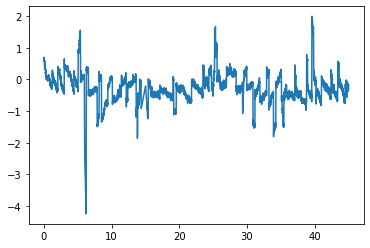

In [54]:
plt.plot(y_data,dt_array['Moving_Average'])

In [55]:
# create dataframe
data = {'Time':y_data,'POS':dt_array['Moving_Average']}
df = pd.DataFrame(data)

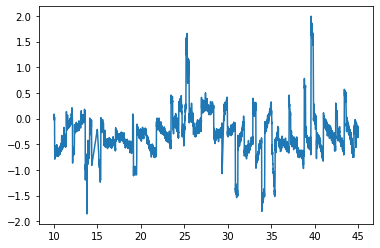

In [56]:
# Plot specific range
x_start = 10
x_end = 90

# Filter the data points within the disired range using boolean indexing
mask = (df['Time'] >= x_start) & (df['Time'] <= x_end)
x_data_range = df.loc[mask]
#y_data_range = y_data[mask]

# create plot


plt.plot(x_data_range['Time'],x_data_range['POS'])

In [57]:
# Test 20 point
data = {'Time':x_data_range['Time'],'POS':x_data_range['POS']}
df_test = pd.DataFrame(data)

In [58]:
# Determine the integration window
def check_sign(x):
    if x > 0:
        return "Positive"
    else:
        return "Negative"
df_test['Sign'] = df_test['POS'].apply(check_sign)

In [59]:
# Condition window width 
def calculate_start_end(row):
    global last_positive, last_negative
    if row['Sign'] == 'Positive':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Positive':
            last_positive = row['Time']
            return last_positive, '', '', ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Positive':
            pos_end = row['Time']
            last_positive = ''
            return '', pos_end, '', ''
        else:
            return '', '', '', ''
    elif row['Sign'] == 'Negative':
        if row.name == 0 or df_test.loc[row.name - 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', last_negative, ''
        elif row.name < len(df_test) - 1 and df_test.loc[row.name + 1, 'Sign'] != 'Negative':
            last_negative = row['Time']
            return '', '', '', last_negative
        else:
            return '', '', '', ''
    else:
        return '', '', '', ''

# Initialize the last positive and negative values to empty strings 
last_positive = ''
last_negative = ''

# Reset the index of the DataFrame
df_test = df_test.reset_index(drop=True)

# Apply the custom function to create new columns
df_test['PosTim_Start'], df_test['PosTim_End'], df_test['NegTim_Start'], df_test['NegTim_End'] = zip(*df_test.apply(calculate_start_end, axis=1))

# Fill the empty cells with an empty string
df_test['PosTim_Start'] = df_test['PosTim_Start'].fillna('') 
df_test['PosTim_End'] = df_test['PosTim_End'].fillna('')
df_test['NegTim_Start'] = df_test['NegTim_Start'].fillna('')
df_test['NegTim_End'] = df_test['NegTim_End'].fillna('')

# Print the resulting dataframe 
print(df_test)

          Time       POS      Sign PosTim_Start PosTim_End NegTim_Start  \
0      10.0000 -0.001507  Negative                                 10.0   
1      10.0033  0.009147  Positive      10.0033                           
2      10.0067  0.015820  Positive                                        
3      10.0100  0.014433  Positive                   10.01                
4      10.0133 -0.003134  Negative                              10.0133   
...        ...       ...       ...          ...        ...          ...   
10498  44.9933 -0.152859  Negative                                        
10499  44.9967 -0.167592  Negative                                        
10500  45.0000 -0.166138  Negative                                        
10501  45.0033 -0.198286  Negative                                        
10502  45.0067 -0.288238  Negative                                        

      NegTim_End  
0                 
1                 
2                 
3                 
4   

#### Positive Time Start Trimming

In [60]:
# Select the non-empty values in the 'Pos_Start' column
pos_start_values = df_test.loc[df_test['PosTim_Start'] != '', 'PosTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_pos_start_values = []
for value in pos_start_values:
    rounded_pos_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
postim_start_values = np.array(rounded_pos_start_values)

# Print the non-empty values
print(postim_start_values)

[10.   10.01 10.04 10.05 10.08 11.44 11.58 11.88 11.95 11.96 12.   12.
 13.11 13.15 13.26 13.31 13.36 13.4  13.45 13.45 13.48 13.52 14.13 15.41
 19.07 19.1  19.13 19.14 21.89 22.11 23.48 23.79 23.89 23.98 24.   24.15
 24.37 25.07 25.08 25.09 25.59 25.62 25.66 25.83 25.87 25.96 26.88 26.97
 29.54 29.57 31.83 32.89 34.59 34.62 34.65 34.68 34.69 34.71 34.77 37.06
 38.8  39.57 39.88 39.89 40.   40.04 40.07 40.09 40.12 40.12 41.01 41.07
 42.42 43.41 43.71]


#### Poisitive Time end Trimming

In [61]:
# Select the non-empty values in the 'Pos_End' column
pos_end_values = df_test.loc[df_test['PosTim_End'] != '', 'PosTim_End'].values

# Round the values in the 'Pos_End' column to two decimal places
rounded_pos_end_values = []
for value in pos_end_values:
    rounded_pos_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
postim_end_values = np.array(rounded_pos_end_values)

# Print the non-empty values
print(postim_end_values)

[ 9.99 10.02 10.03 10.07 11.44 11.56 11.87 11.93 12.12 13.1  13.15 13.26
 13.33 13.38 13.42 13.49 13.59 19.07 19.09 19.11 23.66 23.78 23.87 23.98
 24.02 24.74 25.05 25.07 25.56 25.6  25.62 25.78 25.85 25.93 25.95 28.37
 29.54 29.95 31.81 33.22 34.58 34.61 34.66 34.67 34.74 35.04 37.22 38.94
 39.86 39.96 39.99 40.05 40.06 40.12 41.01 41.06 42.59 43.61 43.7 ]


In [62]:
# # Read the dataset again
# path = os.getcwd()
# dirname = os.path.dirname(path)
# data_file = 'data/raw_pd0013_1.xlsx'
# data_path = os.path.join(dirname,data_file)
# # data = pd.read_csv(data_path)
# data= pd.read_excel(data_path)

In [63]:
# Rename columns
data = data_hc.rename(columns={data_13.columns.values[0]:"Position",
                               data_13.columns.values[1]:'Time'})

#### Map the start positive Time to POS in raw data

In [64]:
# Create a dictionary from the mapping list
mapping_list = postim_start_values

# Map the values to the 'POS' column in raw
mapped_posSt = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_posSt

2999     0.0605
3002     0.0202
3011    -0.1815
3014    -0.1008
3023    -0.0605
          ...  
12302    2.2177
12320    2.3185
12725    5.1815
13022    7.6411
13112    7.2984
Name: Time, Length: 72, dtype: float64

#### Map the End positive Time to POS in raw data

In [65]:
# Create a dictionary from the mapping list
mapping_list = postim_end_values

# Map the values to the 'POS' column in raw
mapped_posEnd = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_posEnd


2996     0.0000
3005     0.0403
3008    -0.0605
3020    -0.2419
3431    -2.6210
3467    -3.2863
3560    -3.7500
3578    -3.9113
3635    -4.1532
3929    -6.3710
3944    -6.0685
3977    -6.4516
3998    -6.6734
4013    -6.7540
4025    -6.7540
4046    -6.9355
4076    -6.9960
5720    -1.6532
5726    -1.8347
5732    -1.8347
7097     7.8024
7133     7.3992
7160     7.5806
7193     7.9234
7205     7.9234
7421     9.4355
7514     9.6976
7520     9.8387
7667     9.9597
7679     8.8710
7685     8.7298
7733     8.7903
7754     8.2056
7778     8.1855
7784     8.2258
8510     3.3669
8861     0.9499
8984     0.3629
9542    -3.7702
9965    -6.1089
10373   -9.2540
10382   -9.1129
10397   -9.4355
10400   -9.2742
10421   -9.3548
10511   -9.7581
11165   -5.5645
11681   -1.3710
11957   -0.1008
11987    0.1008
11996    0.0806
12014    0.1815
12017    0.1210
12035    0.1411
12302    2.2177
12317    2.0766
12776    5.5242
13082    7.5403
13109    7.2984
Name: Time, dtype: float64

In [66]:
# postim_start_values = [1, 2, 3,4,5,6]  # Length 100
# mapped_posSt = [1, 2, 3,4]         # Length 80

# # Check lengths and truncate longer column 
# if len(postim_start_values) > len(mapped_posSt): 
#     postim_start_values = postim_start_values[:len(mapped_posSt)]  # Truncate to 80
# elif len(mapped_posSt) > len(postim_start_values):
#     mapped_posSt = mapped_posSt[:len(postim_start_values)]      # Truncate to 100

# # Construct DataFrame    
# data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}       
# param_gain_start = pd.DataFrame(data_param)

#### Velocity param positive dataframe

In [67]:
# # column miss match
# Check lengths and truncate longer column 
if len(postim_start_values) > len(mapped_posSt): 
    postim_start_values = postim_start_values[:len(mapped_posSt)] 
elif len(mapped_posSt) > len(postim_start_values):
    mapped_posSt = mapped_posSt[:len(postim_start_values)]      

# Now columns have equal length 
data_param = {'positive_x1':postim_start_values,'positive_y1':mapped_posSt}             
param_vel_start = pd.DataFrame(data_param)

data_param= {'positive_x2':postim_end_values,'positive_y2':mapped_posEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_gain_start = param_vel_start.reset_index(drop=True)
param_gain_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_positive_final = param_vel_final.fillna(method='ffill')
param_vel_positive_final
#param_gain_final


,positive_x1,positive_y1,positive_x2,positive_y2
2999,10.00,0.0605,NaN,NaN
3002,10.01,0.0202,NaN,NaN
3011,10.04,-0.1815,NaN,NaN
3014,10.05,-0.1008,NaN,NaN
3023,10.08,-0.0605,NaN,NaN
...,...,...,...,...
12017,41.07,7.2984,40.06,0.1210
12317,41.07,7.2984,41.06,2.0766
12776,41.07,7.2984,42.59,5.5242
13082,41.07,7.2984,43.61,7.5403


### Velocity for Positive peak calculation

In [68]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_positive_final['slope'] = (param_vel_positive_final['positive_y2'] - param_vel_positive_final['positive_y1']) / (param_vel_positive_final['positive_x2'] - param_vel_positive_final['positive_x1'])

# abs
param_vel_positive_final['slope'] = abs(param_vel_positive_final['slope'])

# Remove unwant values
#param_gain_positive_final.loc[param_gain_positive_final['slope'] > 1.09, 'slope'] = np.nan  

# Calculate the average slope
average_positive_slope = abs(param_vel_positive_final['slope'].mean())

# Print the average slope
print(average_positive_slope)

inf


In [69]:
param_vel_positive_final

,positive_x1,positive_y1,positive_x2,positive_y2,slope
2999,10.00,0.0605,NaN,NaN,NaN
3002,10.01,0.0202,NaN,NaN,NaN
3011,10.04,-0.1815,NaN,NaN,NaN
3014,10.05,-0.1008,NaN,NaN,NaN
3023,10.08,-0.0605,NaN,NaN,NaN
...,...,...,...,...,...
12017,41.07,7.2984,40.06,0.1210,7.106337
12317,41.07,7.2984,41.06,2.0766,522.180000
12776,41.07,7.2984,42.59,5.5242,1.167237
13082,41.07,7.2984,43.61,7.5403,0.095236


#### Negative Time Start Trimming

In [70]:
# Select the non-empty values in the 'Pos_Start' column
neg_start_values = df_test.loc[df_test['NegTim_Start'] != '', 'NegTim_Start'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_start_values = []
for value in neg_start_values:
    rounded_neg_start_values.append(round(value - 0.003, 2))

# Convert the list of rounded values back to a NumPy array
negtim_start_values = np.array(rounded_neg_start_values)

# Print the non-empty values
print(negtim_start_values)

[10.   10.01 10.04 10.05 10.06 10.09 11.46 11.58 11.89 11.95 11.96 12.
 12.14 13.12 13.17 13.28 13.35 13.4  13.44 13.45 13.46 13.51 13.61 14.13
 15.42 19.09 19.11 19.13 19.14 21.9  22.11 23.68 23.8  23.89 24.   24.04
 24.15 24.76 25.07 25.09 25.58 25.62 25.64 25.8  25.87 25.95 25.97 26.88
 28.39 29.56 29.97 31.83 33.24 34.6  34.63 34.65 34.68 34.69 34.76 35.06
 37.24 38.96 39.88 39.88 39.98 40.01 40.07 40.08 40.09 40.12 40.14 41.03
 41.08 42.61 43.63 43.72]


#### Negative Time End Trimming

In [71]:
# Select the non-empty values in the 'Pos_Start' column
neg_end_values = df_test.loc[df_test['NegTim_End'] != '', 'NegTim_End'].values

# Round the values in the 'Pos_Start' column to two decimal places
rounded_neg_end_values = []
for value in neg_end_values:
    rounded_neg_end_values.append(round(value - 0.02, 2))

# Convert the list of rounded values back to a NumPy array
negtim_end_values = np.array(rounded_neg_end_values)

# Print the non-empty values
print(negtim_end_values)

[10.06 11.42 11.56 11.86 11.93 11.94 11.98 13.09 13.13 13.24 13.29 13.43
 13.46 13.5  14.11 15.39 19.05 19.08 19.11 19.12 21.87 22.09 23.46 23.77
 23.87 23.96 24.13 24.35 25.05 25.07 25.57 25.64 25.81 25.94 26.86 26.95
 29.52 29.55 31.81 32.87 34.57 34.6  34.63 34.66 34.69 34.75 37.04 38.78
 39.55 39.98 40.02 40.07 40.1  40.99 41.05 42.4  43.39 43.69]


#### Map the start negative Time to POS in raw data

In [72]:
# Create a dictionary from the mapping list
mapping_list = negtim_start_values

# Map the values to the 'POS' column in raw
mapped_negSt = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_negSt

2999     0.0605
3002     0.0202
3011    -0.1815
3014    -0.1008
3017    -0.0202
          ...  
12308    2.0565
12323    2.1371
12782    5.1008
13088    6.9960
13115    7.5202
Name: Time, Length: 75, dtype: float64

#### Map the End of negative Time to POS in raw data

In [73]:
# Create a dictionary from the mapping list
mapping_list = negtim_end_values

# Map the values to the 'POS' column in raw
mapped_negEnd = data.loc[data['Position'].isin(mapping_list),'Time']
mapped_negEnd

3017     -0.0202
3425     -3.2258
3467     -3.2863
3557     -3.9113
3578     -3.9113
3581     -3.7903
3593     -4.0524
3926     -6.1694
3938     -6.4919
3971     -6.5927
3986     -6.6331
4028     -6.8145
4037     -7.0161
4049     -7.0565
4232     -8.8306
4616    -10.3427
5714     -2.5202
5723     -1.8347
5732     -1.8347
5735     -1.5524
6560      3.7702
6626      3.9919
7037      6.4516
7130      7.1371
7160      7.5806
7187      7.7016
7238      8.2056
7304      8.4476
7514      9.6976
7520      9.8387
7670      8.9113
7691      8.7298
7742      8.3065
7781      8.1653
8057      6.3105
8084      5.8669
8855      0.8738
8864      0.9879
9542     -3.7702
9860     -6.1895
10370    -8.9919
10379    -9.3145
10388    -9.4355
10397    -9.4355
10406    -9.4355
10424    -9.4758
11111    -6.4516
11633    -3.0645
11864    -1.6331
11993     0.0605
12005    -0.0403
12020     0.1210
12029    -0.1008
12296     1.4113
12314     2.0363
12719     4.2339
13016     6.3306
13106     7.2581
Name: Time, dt

#### Velocity param negative dataframe

In [74]:
# column miss match
# Check lengths and truncate longer column 
if len(negtim_start_values) > len(mapped_negSt): 
    negtim_start_values = negtim_start_values[:len(mapped_negSt)] 
elif len(mapped_negSt) > len(negtim_start_values):
    mapped_negSt = mapped_negSt[:len(negtim_start_values)]  


data_param = {'negative_x1':negtim_start_values,'negative_y1':mapped_negSt}             
param_vel_start = pd.DataFrame(data_param)
data_param= {'negative_x2':negtim_end_values,'negative_y2':mapped_negEnd}
param_vel_end = pd.DataFrame(data_param)

# Reset the indices of the DataFrames
param_vel_start = param_vel_start.reset_index(drop=True)
param_vel_end = param_vel_end.reset_index(drop=True)

# Concatenate the DataFrames horizontally
param_vel_negative_final = pd.concat([param_vel_start,param_vel_end],axis=1)
param_vel_negative_final = param_vel_negative_final.fillna(method='ffill')
param_vel_negative_final


,negative_x1,negative_y1,negative_x2,negative_y2
0,10.00,0.0605,10.06,-0.0202
1,10.01,0.0202,11.42,-3.2258
2,10.04,-0.1815,11.56,-3.2863
3,10.05,-0.1008,11.86,-3.9113
4,10.06,-0.0202,11.93,-3.9113
...,...,...,...,...
70,40.14,2.0565,43.69,7.2581
71,41.03,2.1371,43.69,7.2581
72,41.08,5.1008,43.69,7.2581
73,42.61,6.9960,43.69,7.2581


### Velocity for Negative peak calculation

In [75]:
# Calculate the difference between y2 and y1 divided by the difference between x2 and x1
param_vel_negative_final['slope'] = (param_vel_negative_final['negative_y2'] - param_vel_negative_final['negative_y1']) / (param_vel_negative_final['negative_x2'] - param_vel_negative_final['negative_x1'])

# abs
param_vel_negative_final['slope'] = abs(param_vel_negative_final['slope'])

param_vel_negative_final['slope'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Remove unwant values
#param_gain_negative_final.loc[(param_gain_negative_final['slope'] < 0.80) |  
#                              (param_gain_negative_final['slope'] > 1.09), 
#                              'slope'] = np.nan
# Calculate the average slope
average_negative_slope = abs(param_vel_negative_final['slope'].mean())

# Print the average slope
print(average_negative_slope)

1.6263283199409495


In [76]:
param_vel_negative_final

,negative_x1,negative_y1,negative_x2,negative_y2,slope
0,10.00,0.0605,10.06,-0.0202,1.345000
1,10.01,0.0202,11.42,-3.2258,2.302128
2,10.04,-0.1815,11.56,-3.2863,2.042632
3,10.05,-0.1008,11.86,-3.9113,2.105249
4,10.06,-0.0202,11.93,-3.9113,2.080802
...,...,...,...,...,...
70,40.14,2.0565,43.69,7.2581,1.465239
71,41.03,2.1371,43.69,7.2581,1.925188
72,41.08,5.1008,43.69,7.2581,0.826552
73,42.61,6.9960,43.69,7.2581,0.242685


In [77]:
total_vel = (average_positive_slope + average_negative_slope)/2


total_vel

inf

### Gain calculation

In [79]:
speed = 2
total_gain = total_vel/speed
print("The gain for this subject is:",total_gain)

The gain for this subject is: inf
